In [2]:
from src.utils.train_utils import *
from src.utils.test_utils import *
from src.utils.feature_analyzer import *
from src.utils.plot_utils import *
import os

### Import the data

In [3]:
train_df_path = '../../data/synth_data_train_labeled.csv'
test_df_path = '../../data/synth_data_test_labeled.csv'
supp_df_path = '../../data/Supp_dfs'
supp_dfs = os.listdir(supp_df_path)
print(f'Supplement data: {supp_dfs}')
fi_dir = 'feature_importance'
target_model_dir = "../../model"

Supplement data: ['synth_data_supp_pla_historie_ontwikkeling.csv', 'synth_data_supp_persoon_leeftijd_bij_onderzoek.csv']


In [4]:
cols_to_drop = ['checked', 'Ja', 'Nee']
train_df = add_checked(pd.read_csv(train_df_path))
X_train = train_df.astype(np.float32)
y_train = train_df['checked']

In [5]:
test_df = add_checked(pd.read_csv(test_df_path))
X_test = test_df.drop(cols_to_drop, axis=1)
X_test = X_test.astype(np.float32)
y_test = test_df['checked']

### Manipulate the data

In [6]:
# Manipulate the data to reduce/increase bias
def data_manipulator(X, y, remove_features=1, add_supp=0, to_add_f=None, overwrite=0, verbose=0):
    ########INSERT DATA MANIPULATION CODE HERE##########
    
    if add_supp:
        if to_add_f is not None:
            for supp in to_add_f:
                supp_path = os.path.join(supp_df_path, supp)
                supp_df = add_checked(pd.read_csv(supp_path)).astype(np.float32)
                
                # Append the rows of df2 to df1
                X = pd.concat([X, supp_df], ignore_index=True)
                
                supp_y = supp_df['checked']
                y = pd.concat([y, supp_y], ignore_index=True)
                    
        if overwrite:
            # Save the combined DataFrame to a new CSV file
            X.to_csv(train_df_path, index=False)
            print(f'Wrote to file {train_df_path}')

        print("Data augmentation complete.")
    
    if remove_features:
        problem_features = filter_features(X.columns)
    
        for feature in problem_features:
            X[feature] = X[feature].mean() # Average values of problematic features to effectively 'remove' them from the model
            if verbose:
                print(f'Feature {feature} has been processed.')
        print("Feature processing complete.")
    
    print(X.shape)
    return X, y
    ####################################################

In [7]:
to_add = ['synth_data_supp_persoon_leeftijd_bij_onderzoek.csv', 'synth_data_supp_pla_historie_ontwikkeling.csv']
X_prime, y_prime = data_manipulator(X_train, y_train, remove_features=1, add_supp=1, to_add_f=to_add, overwrite=0, verbose=0) # only set overwrite to 1 if you want to add supplementary data to csv and set back to 0 afterwards. Do not run twice!

Data augmentation complete.
Feature processing complete.
(190500, 318)


### Evaluate feature importances

In [8]:
# uncomment if you need to re-evaluate
latest_ver_name = get_versioned_name(fi_dir, 'fi_v', '.pkl', create_new=False) # set to true to create new version
latest_ver_path = fi_dir + '/' + latest_ver_name
# fa1 = FeatureAnalyzer()
# fa1.evaluate_importance(dataframe=X_prime, target='checked', add_drop=['Ja', 'Nee'], filepath=latest_ver_path) # Uncomment this line if you don't have the feature_importance.pkl file

In [9]:
if all(col in X_prime.columns for col in cols_to_drop):
    X_prime = X_prime.drop(['checked', 'Ja', 'Nee'], axis=1)
    
print(f'Loading feature importance data from {latest_ver_name}')

print(latest_ver_path)

Loading feature importance data from fi_v2.pkl
feature_importance/fi_v2.pkl


In [10]:
fa2 = FeatureAnalyzer()
fa2.load_importance(filepath=latest_ver_path)

In [11]:
fad = fa2.feature_importance_as_dict(column_names=X_prime.columns, normalize=True)

sorted_fi = dict(sorted(fad.items(), key=lambda item: item[1], reverse=True)[:10])

print("Top 10 most important features according to permutation importance:")
for rank, feature in enumerate(sorted_fi):
    print(f'{rank+1}: {feature} - {sorted_fi[feature]:.4f}')

Top 10 most important features according to permutation importance:
1: persoon_leeftijd_bij_onderzoek - 1.0000
2: pla_historie_ontwikkeling - 0.7965
3: ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden - 0.4008
4: instrument_ladder_huidig_activering - 0.3229
5: contacten_soort_afgelopenjaar_document__uitgaand_ - 0.2983
6: contacten_onderwerp_no_show - 0.2879
7: relatie_overig_actueel_vorm__kostendeler - 0.2850
8: ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie - 0.2023
9: pla_hist_pla_categorie_doelstelling_16 - 0.1863
10: instrument_reden_beeindiging_historie_succesvol - 0.1812


In [12]:
X_en, top_features_en = translate_cols(X_prime, sorted_fi)

# FEATURES WERE ALREADY NORMALIZED
# print("Top 10 most important features according to permutation importance (normalized):")
# for rank, feature in enumerate(top_features_en):
#     print(f'{rank+1}: {feature} - {top_features_en[feature]:.4f}')

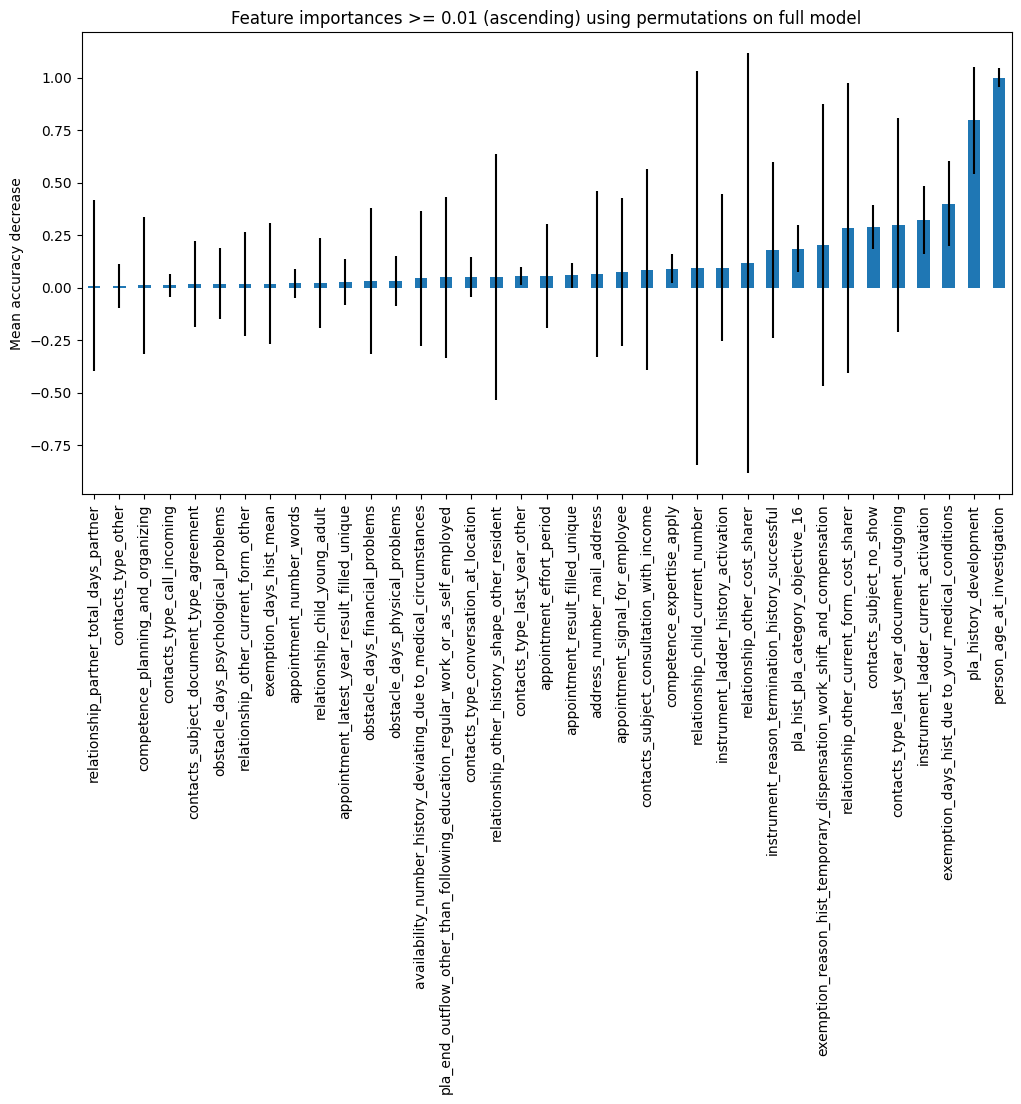

In [13]:
fa2.plot_importance(column_names=X_en.columns, min_val=0.01)

### Visualize modified data distributions (Top 3)

{'18-23': 2100, '23-28': 2000, '28-33': 2000, '33-38': 900, '38-42': 2200, '47-52': 0, '52-57': 400, '57-62': 1000, '62-67': 1600}


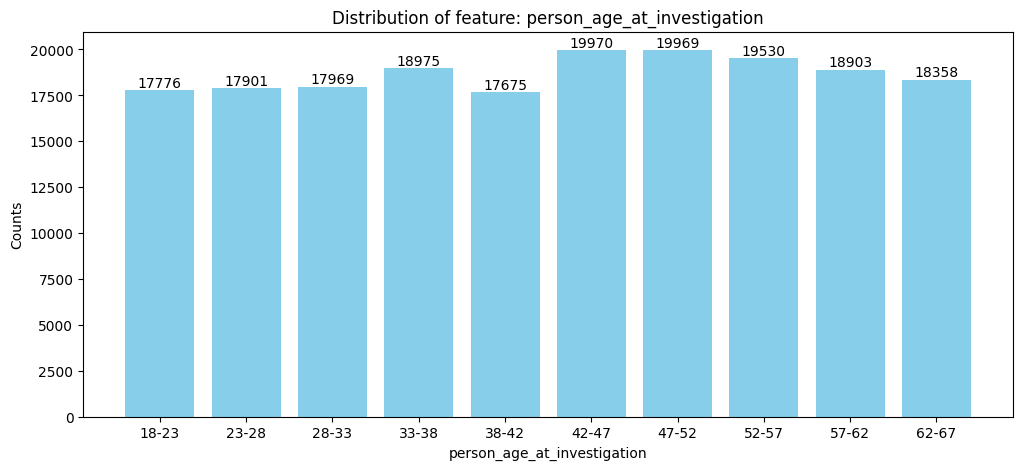

{0.0: 24500}


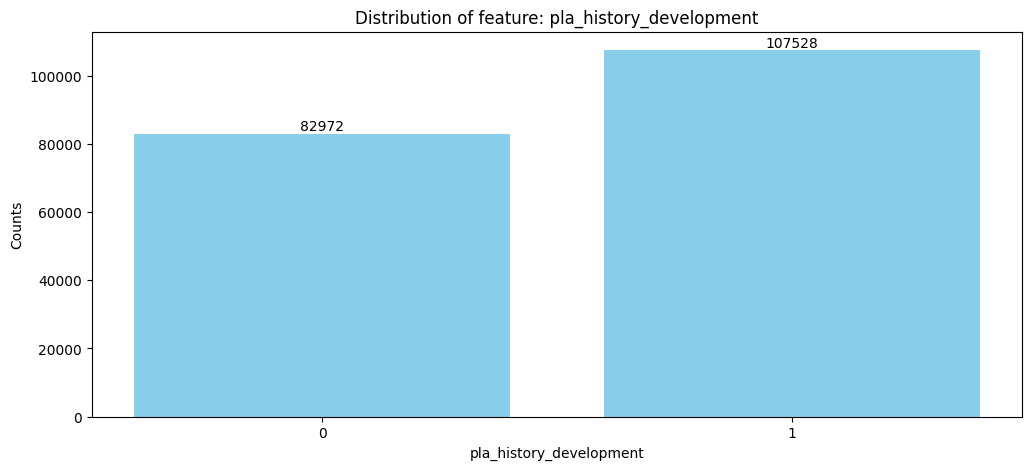

In [14]:
for feature in list(top_features_en.keys())[:2]:
    plot_distribution(X_en[feature], feature)

### Train model on modified data

In [15]:
# uncomment to train new model
model_path = target_model_dir + '/' + get_versioned_name(target_model_dir, 'gboost1_v', '.onnx', create_new=True) # set to true to create new version
run(X_prime, y_prime, model_path)

# model_path = target_model_dir + '/' + get_versioned_name(target_model_dir, 'gboost1_v', '.onnx', create_new=False) # set to true to create new version

Training model...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
      Iter       Train Loss   Remaining Time 
         1           0.9681           10.62m
         2           0.8988           10.54m
         3           0.8446           10.48m
         4           0.8074           10.46m
         5           0.7712           10.44m
         6           0.7420           10.42m
         7           0.7194           10.42m
         8           0.6984           10.46m
         9           0.6793           10.33m
        10           0.6619           10.34m
      Iter       Train Loss   Remaining Time 
         1           0.9668            5.32m
         2           0.8973            5.32m
         3           0.8429            5.32m
         4           0.8024            5.30m
         5           0.7705            5.30m
         6           0.7463            5.29m
         7           0.7232            5.28m
         8           0.7017            5.26m
         9           

In [ ]:
# Let's load the model
new_session = rt.InferenceSession(model_path)

# Let's predict the target
y_pred_onnx =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)